In [ ]:
requirements = [
    'torch', 
    'transformers==4.10.2',
    'tokenizers==0.10.3',
    'numpy==1.21.2',
    'pandas==1.3.3',
    'tensorflow==2.6.0'
]

with open('requirements.txt', 'w') as file:
    file.write('\n'.join(requirements))

!pip install -r requirements.txt

In [3]:
import pandas as pd
import numpy as np
import random
import torch
import tensorflow as tf

random.seed(23)
np.random.seed(23)
torch.manual_seed(23)
torch.cuda.manual_seed(23)
tf.random.set_seed(23)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [5]:
import os

IS_ON_COLAB = bool(os.getenv("COLAB_RELEASE_TAG"))

if IS_ON_COLAB :
  !pip install transformers==4.28.0
  !pip install tokenizers datasets sentencepiece huggingface_hub[cli] accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.7/67.7 kB 3.0 MB/s eta 0:00:00


In [6]:
from transformers import pipeline
from datasets import load_dataset
from transformers import logging
import torch
from sklearn.metrics import classification_report
from time import time
from transformers import AutoTokenizer
import scipy

logging.set_verbosity_error()

**Loading the dataset from HuggingFace Datasets**

In [7]:
banking = load_dataset("PolyAI/banking77", name = 'split')

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Viewing the Dataset

In [8]:
banking['train']

Dataset({
    features: ['text', 'label'],
    num_rows: 10003
})

In [9]:
banking['test']

Dataset({
    features: ['text', 'label'],
    num_rows: 3080
})

Splitting the Dataset into train, test and validation sets

In [10]:
banking_validation = banking['test'].train_test_split(test_size = 0.5, seed = 23)
banking_validation

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1540
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1540
    })
})

In [11]:
banking_test = banking_validation['test']

In [12]:

banking_val = banking_validation['train']

In [13]:
banking_train = banking['train']

In [14]:
pip install scikit-learn

Feature extraction using the Term Frequency-Inverse Document Frequency (TF-IDF) vectorizer

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(banking_train["text"])
X_val_tfidf = vectorizer.transform(banking_val["text"])
X_test_tfidf = vectorizer.transform(banking_test["text"])

y_train = banking_train["label"]
y_val = banking_val["label"]
y_test = banking_test["label"]

**Feature Extraction and Logistic Regression**

In [16]:
from sklearn.linear_model import LogisticRegression

```

#Creating a logistic regression model

from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 5, 10],
    'max_iter': [500, 1000],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs'],
    'fit_intercept': [True, False],
    'random_state': [23],
}

logistic_regression_model = LogisticRegression()


grid_search = GridSearchCV(logistic_regression_model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train_tfidf, y_train)


#Printing the best parameters found

print("Best Hyperparameters:", grid_search.best_params_)

```

In [17]:
#Choosing the best parameters based on accuracy and f1 score

logistic_regression_params = {
    'C': 5,
    'fit_intercept': True,
    'max_iter': 500,
    'penalty': 'l2',
    'random_state': 23,
    'solver': 'lbfgs'
}

In [18]:
#fitting the best hyperparameters to the logistic regression model

logistic_regression_model = LogisticRegression(**logistic_regression_params)
logistic_regression_model.fit(X_train_tfidf, y_train)

LogisticRegression(C=5, max_iter=500, random_state=23)

In [19]:
# Validating the model using the validation set, to check the accuracy score and f1 score

y_pred_val = logistic_regression_model.predict(X_val_tfidf)

In [20]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

accuracy = accuracy_score(y_val, y_pred_val)
f1score = f1_score(y_val, y_pred_val, average = 'weighted')
confusion = confusion_matrix(y_val, y_pred_val)
classification_rep = classification_report(y_val, y_pred_val)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1score}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.8837662337662338
F1 Score: 0.884345017860373
Confusion Matrix:
[[16  0  0 ...  0  0  0]
 [ 0 25  0 ...  0  0  0]
 [ 0  0 22 ...  0  0  0]
 ...
 [ 0  0  0 ... 14  0  0]
 [ 0  0  0 ...  0 16  0]
 [ 0  0  0 ...  0  1 16]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       0.96      1.00      0.98        25
           2       0.96      1.00      0.98        22
           3       1.00      1.00      1.00        15
           4       1.00      0.95      0.98        21
           5       0.53      0.67      0.59        15
           6       0.79      0.85      0.81        13
           7       1.00      0.81      0.89        21
           8       0.95      0.91      0.93        22
           9       0.92      0.96      0.94        24
          10       0.94      0.85      0.89        20
          11       0.92      0.85      0.88        27
          12       0.77      0.94      0.85

In [21]:
#Cross checking how the model handles new unseen data using the test set

y_pred_test = logistic_regression_model.predict(X_test_tfidf)

In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

accuracy = accuracy_score(y_test, y_pred_test)
f1score = f1_score(y_test, y_pred_test, average = 'weighted')
confusion = confusion_matrix(y_test, y_pred_test)
classification_rep = classification_report(y_test, y_pred_test)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1score}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.8980519480519481
F1 Score: 0.8979793506326913
Confusion Matrix:
[[22  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  0  0 ...  0  0 17]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        18
           3       0.96      0.88      0.92        25
           4       1.00      0.84      0.91        19
           5       0.80      0.80      0.80        25
           6       0.93      0.96      0.95        27
           7       0.94      0.89      0.92        19
           8       0.95      1.00      0.97        18
           9       1.00      1.00      1.00        16
          10       0.83      0.75      0.79        20
          11       0.86      0.92      0.89        13
          12       0.90      0.86      0.8

In [23]:
#Checking whether the model can predict the label name of custom text

In [24]:
custom_text = ['I have returned an item at ZARA, they say my refund is made, my bank account does not show it']
custom_text_tfidf = vectorizer.transform(custom_text)

In [25]:
pred = logistic_regression_model.predict(custom_text_tfidf)


In [16]:
labels = ["activate_my_card",
    "age_limit",
    "apple_pay_or_google_pay",
    "atm_support",
    "automatic_top_up",
    "balance_not_updated_after_bank_transfer",
    "balance_not_updated_after_cheque_or_cash_deposit",
    "beneficiary_not_allowed" ,
    "cancel_transfer",
    "card_about_to_expire" ,
    "card_acceptance",
    "card_arrival",
    "card_delivery_estimate",
    "card_linking",
    "card_not_working",
    "card_payment_fee_charged",
    "card_payment_not_recognised",
    "card_payment_wrong_exchange_rate",
    "card_swallowed",
    "cash_withdrawal_charge",
    "cash_withdrawal_not_recognised",
    "change_pin" ,

    "compromised_card",
    "contactless_not_working",
    "country_support",
    "declined_card_payment",
    "declined_cash_withdrawal",
    "declined_transfer",
    "direct_debit_payment_not_recognised",
    "disposable_card_limits",
    "edit_personal_details",
    "exchange_charge",
    "exchange_rate",
    "exchange_via_app",
    "extra_charge_on_statement",
    "failed_transfer",
    "fiat_currency_support",
    "get_disposable_virtual_card",
    "get_physical_card",
    "getting_spare_card",
    "getting_virtual_card",
    "lost_or_stolen_card",
    "lost_or_stolen_phone",
    "order_physical_card",

    "passcode_forgotten",
    "pending_card_payment",
    "pending_cash_withdrawal",
    "pending_top_up" ,
    "pending_transfer",
    "pin_blocked",
    "receiving_money",
    "Refund_not_showing_up",
    "request_refund",
    "reverted_card_payment?",
    "supported_cards_and_currencies",
    "terminate_account",
    "top_up_by_bank_transfer_charge",
    "top_up_by_card_charge",
    "top_up_by_cash_or_cheque",
    "	top_up_failed",
    "top_up_limits",
    "top_up_reverted",
    "topping_up_by_card",
    "transaction_charged_twice",
    "transfer_fee_charged",
    "transfer_into_account",

    "transfer_not_received_by_recipient",
    "transfer_timing",
    "unable_to_verify_identity",
    "verify_my_identity",
    "verify_source_of_funds",
    "verify_top_up",
    "virtual_card_not_working",
    "visa_or_mastercard",
    "why_verify_identity",
    "wrong_amount_of_cash_received",
    "wrong_exchange_rate_for_cash_withdrawal"]


In [27]:
label = [labels[i] for i in pred]
label

['Refund_not_showing_up']

**Feature Extraction and Decision Tree**

In [28]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

```

#Creating a decision tree model


param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 2, 5],
    'min_samples_split': [5,10],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'random_state': [23],
}


decision_tree_model = DecisionTreeClassifier()

grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train_tfidf, y_train)

print("Best Hyperparameters:", grid_search.best_params_)

```

In [29]:
Dec_Tr_parameters = {
    'criterion': 'gini',
    'max_depth': None,
    'max_features': None,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'random_state': 23,
    'splitter': 'random'
}

In [30]:
#Fitting the best parameters to the model to get the best accuracy and f1 score

decision_tree_model = DecisionTreeClassifier(**Dec_Tr_parameters )
decision_tree_model.fit(X_train_tfidf, y_train)

DecisionTreeClassifier(min_samples_split=5, random_state=23, splitter='random')

In [31]:
#Predicting the model using validation set

y_pred_val_1 = decision_tree_model.predict(X_val_tfidf)

In [32]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

accuracy = accuracy_score(y_val, y_pred_val_1)
f1score = f1_score(y_val, y_pred_val_1, average = 'weighted')
confusion = confusion_matrix(y_val, y_pred_val_1)
classification_rep = classification_report(y_val, y_pred_val_1)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1score}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.7532467532467533
F1 Score: 0.7547168403656951
Confusion Matrix:
[[15  0  0 ...  0  0  0]
 [ 0 23  0 ...  0  0  0]
 [ 0  0 22 ...  0  0  0]
 ...
 [ 0  0  0 ... 13  0  0]
 [ 0  0  0 ...  0 15  0]
 [ 0  0  0 ...  0  2 12]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        18
           1       0.85      0.92      0.88        25
           2       0.88      1.00      0.94        22
           3       0.74      0.93      0.82        15
           4       0.75      0.86      0.80        21
           5       0.31      0.53      0.39        15
           6       0.64      0.54      0.58        13
           7       0.68      0.62      0.65        21
           8       0.74      0.64      0.68        22
           9       0.90      0.75      0.82        24
          10       0.50      0.50      0.50        20
          11       0.85      0.63      0.72        27
          12       0.56      0.78      0.6

In [33]:
#Cross checking performance of the model on unseen data using the test set

y_pred_test_1 = decision_tree_model.predict(X_test_tfidf)

In [34]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

accuracy = accuracy_score(y_test, y_pred_test_1)
f1score = f1_score(y_test, y_pred_test_1, average = 'weighted')
confusion = confusion_matrix(y_test, y_pred_test_1)
classification_rep = classification_report(y_test, y_pred_test_1)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1score}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.7571428571428571
F1 Score: 0.7579517524354741
Confusion Matrix:
[[20  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  0]
 ...
 [ 0  0  0 ... 13  0  0]
 [ 0  0  0 ...  0 15  0]
 [ 0  0  0 ...  0  1 15]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83        22
           1       0.83      1.00      0.91        15
           2       0.83      0.83      0.83        18
           3       0.90      0.76      0.83        25
           4       0.88      0.79      0.83        19
           5       0.62      0.64      0.63        25
           6       0.84      0.78      0.81        27
           7       0.87      0.68      0.76        19
           8       0.88      0.83      0.86        18
           9       0.94      0.94      0.94        16
          10       0.56      0.50      0.53        20
          11       0.53      0.77      0.62        13
          12       0.71      0.77      0.7

In [35]:
#Checking the model's performance on a custom text

In [36]:
custom_text = ['I have returned an item at ZARA, they say my refund is made, my bank account does not show it']
custom_text_tfidf = vectorizer.transform(custom_text)

pred = decision_tree_model.predict(custom_text_tfidf)


In [37]:
label = [labels[i] for i in pred]
label

['Refund_not_showing_up']

**Feature extraction with Naive Bayes (Multinomial NB)**

In [38]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB, GaussianNB

```

#Creating a Multinomial NB model


param_grid_multinomial = {
    'alpha': [0.1,0.5, 1.0, 2.0],
    'fit_prior': [True, False],
}


multinomial_nb_model = MultinomialNB()


grid_search_multinomial = GridSearchCV(multinomial_nb_model, param_grid_multinomial, cv=5, n_jobs=-1)

grid_search_multinomial.fit(X_train_tfidf, y_train)


print("Best Hyperparameters:", grid_search_multinomial.best_params_)

```

In [39]:
multinomial_nb_params = {'alpha': 0.1,
                   'fit_prior': False
}

In [40]:
#Fitting the best parameters into the model
best_multinomial_nb_model = MultinomialNB(**multinomial_nb_params)
best_multinomial_nb_model.fit(X_train_tfidf, y_train)

MultinomialNB(alpha=0.1, fit_prior=False)

In [41]:
#Using the validation set to predict the results namely accuracy and F1 score

y_pred_val_2 = best_multinomial_nb_model.predict(X_val_tfidf)

In [42]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

accuracy = accuracy_score(y_val, y_pred_val_2)
f1score = f1_score(y_val, y_pred_val_2, average = 'weighted')
confusion = confusion_matrix(y_val, y_pred_val_2)
classification_rep = classification_report(y_val, y_pred_val_2)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1score}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.8649350649350649
F1 Score: 0.864916052386723
Confusion Matrix:
[[16  0  0 ...  0  0  0]
 [ 0 24  0 ...  0  0  0]
 [ 0  0 22 ...  0  0  0]
 ...
 [ 0  0  0 ... 13  0  0]
 [ 0  0  0 ...  0 17  0]
 [ 0  0  0 ...  0  0 17]]
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91        18
           1       1.00      0.96      0.98        25
           2       0.96      1.00      0.98        22
           3       0.93      0.93      0.93        15
           4       0.95      0.95      0.95        21
           5       0.62      0.67      0.65        15
           6       0.77      0.77      0.77        13
           7       0.80      0.76      0.78        21
           8       0.95      0.95      0.95        22
           9       1.00      1.00      1.00        24
          10       1.00      0.90      0.95        20
          11       0.91      0.78      0.84        27
          12       0.79      0.83      0.81

In [43]:
#Cross checking the performance of the model on unseen data using the test set

y_pred_test_2 = best_multinomial_nb_model.predict(X_test_tfidf)

In [44]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

accuracy = accuracy_score(y_test, y_pred_test_2)
f1score = f1_score(y_test, y_pred_test_2, average = 'weighted')
confusion = confusion_matrix(y_test, y_pred_test_2)
classification_rep = classification_report(y_test, y_pred_test_2)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1score}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.8720779220779221
F1 Score: 0.8720839701350177
Confusion Matrix:
[[22  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  0  0 ... 15  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  0  0 ...  0  0 17]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       0.94      1.00      0.97        15
           2       0.90      1.00      0.95        18
           3       0.95      0.84      0.89        25
           4       0.94      0.84      0.89        19
           5       0.90      0.72      0.80        25
           6       0.96      0.96      0.96        27
           7       0.83      0.79      0.81        19
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        16
          10       0.78      0.70      0.74        20
          11       0.93      1.00      0.96        13
          12       0.95      0.91      0.9

In [48]:
#Checking model's performance on a custom text

custom_text = ['I have returned an item at ZARA, they say my refund is made, my bank account does not show it']
custom_text_tfidf = vectorizer.transform(custom_text)

pred = best_multinomial_nb_model.predict(custom_text_tfidf)


In [49]:
label = [labels[i] for i in pred]
label

['Refund_not_showing_up']

In [50]:
#Moving on to more sophisticated fine tuning models

In [32]:
from datasets import DatasetDict

banking = DatasetDict({'train' :banking_train,
                            'val' : banking_val,
                            'test' : banking_test})

In [33]:
y_train = banking_train["label"]
y_val = banking_val["label"]
y_test = banking_test["label"]

**Bert-Base-Uncased**

In [34]:
model_name = "bert-base-uncased"
from transformers import AutoTokenizer, BertForSequenceClassification, AdamW
tokenizer = AutoTokenizer.from_pretrained(model_name)


def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


banking_encoded = banking.map(tokenize, batched=True, batch_size=None)
banking_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"],
)
banking_encoded.set_format("torch")
banking_encoded

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10003
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1540
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1540
    })
})

In [35]:
from transformers import AutoModelForSequenceClassification

device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_labels = 77
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=77
).to(device )


In [36]:
from sklearn.metrics import f1_score, accuracy_score


def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(axis=-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

Hypertuning to find best parameters

In [56]:
from transformers import TrainingArguments
from transformers import Trainer

learning_rates = [2e-5, 3e-5]
batch_sizes = [64, 128]
num_epochs = [3, 4]


for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
            print(f"Hyperparameters: lr={learning_rate}, batch_size={batch_size}, epochs={epochs}")


            training_args = TrainingArguments(
                output_dir="results",
                optim="adamw_torch",
                learning_rate=learning_rate,
                weight_decay=0.01,
                per_device_train_batch_size=batch_size,
                num_train_epochs=epochs,
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                evaluation_strategy="epoch",
                save_strategy="epoch",
                disable_tqdm=False,
                logging_steps= len(banking_encoded["train"])// batch_size,
                seed= 23
            )


            trainer = Trainer(
                model=model,
                args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=banking_encoded["train"],
                eval_dataset=banking_encoded["val"],
            )


            trainer.train()


Hyperparameters: lr=2e-05, batch_size=64, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.937000,3.308211,0.450000,0.393129
2,2.924800,2.538461,0.656494,0.619124
3,2.431500,2.315643,0.701299,0.666151


Hyperparameters: lr=2e-05, batch_size=64, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.911300,1.514403,0.813636,0.796126
2,1.242300,1.091380,0.857143,0.845529
3,0.921300,0.902495,0.868182,0.858962
4,0.788100,0.845090,0.872078,0.864576


Hyperparameters: lr=2e-05, batch_size=128, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.672300,0.662244,0.889610,0.887683
2,0.496200,0.576182,0.901299,0.900509
3,0.409600,0.543437,0.904545,0.904607


Hyperparameters: lr=2e-05, batch_size=128, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.309900,0.445445,0.912987,0.913309
2,0.221400,0.418481,0.910390,0.911181
3,0.180500,0.389163,0.913636,0.913935
4,0.168000,0.379410,0.913636,0.914253


Hyperparameters: lr=3e-05, batch_size=64, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.142600,0.375327,0.910390,0.911445
2,0.078500,0.328574,0.921429,0.921940
3,0.048200,0.334766,0.920779,0.921727


Hyperparameters: lr=3e-05, batch_size=64, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.040000,0.386684,0.912338,0.913158
2,0.023500,0.364369,0.920130,0.920944
3,0.023700,0.396262,0.918182,0.919041
4,0.017700,0.372214,0.920779,0.921560


Hyperparameters: lr=3e-05, batch_size=128, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.014800,0.420599,0.912338,0.913076
2,0.015200,0.397734,0.918831,0.919739
3,0.007700,0.396966,0.922078,0.922888


Hyperparameters: lr=3e-05, batch_size=128, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.008400,0.421783,0.917532,0.918184
2,0.006400,0.454756,0.923377,0.924187
3,0.005100,0.434888,0.921429,0.922402
4,0.007300,0.439372,0.916883,0.917690


In [57]:
#fitting the best parameters in the model 3e-05, 64, 4

from transformers import TrainingArguments
from transformers import Trainer

training_args_best = TrainingArguments(
                output_dir="results",
                optim="adamw_torch",
                learning_rate=3e-5,
                weight_decay=0.01,
                per_device_train_batch_size=128,
                num_train_epochs=3,
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                evaluation_strategy="epoch",
                save_strategy="epoch",
                disable_tqdm=False,
                logging_steps= len(banking_encoded["train"])//128,
                seed = 23
            )



trainer = Trainer(
                model=model,
                args=training_args_best,
                compute_metrics=compute_metrics,
                train_dataset=banking_encoded["train"],
                eval_dataset=banking_encoded["val"],

            )

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.007400,0.473649,0.916883,0.918310
2,0.004800,0.480780,0.916883,0.917119
3,0.003100,0.447733,0.922078,0.923032


TrainOutput(global_step=237, training_loss=0.00506291936155613, metrics={'train_runtime': 182.4664, 'train_samples_per_second': 164.463, 'train_steps_per_second': 1.299, 'total_flos': 1512303955320060.0, 'train_loss': 0.00506291936155613, 'epoch': 3.0})

In [58]:
# evaluating the model performance on the test set

banking_test = banking_encoded["test"]['text']
input_ids = tokenizer(banking_test, padding = True, truncation = True, return_tensors = 'pt')

with torch.no_grad() :
  inputs = input_ids.to('cuda')
  outputs = model(**inputs)
  logits = outputs.logits

probs = torch.softmax(logits, dim=1).cpu().numpy()

y_pred_bert = np.argmax(probs,axis=1)

In [59]:
y_pred_bert

array([35, 29, 73, ..., 65, 24, 38])

In [60]:
from sklearn.metrics import confusion_matrix


accuracy = accuracy_score(y_test, y_pred_bert)
f1score = f1_score(y_test, y_pred_bert, average = 'weighted')
confusion = confusion_matrix(y_test, y_pred_bert)
classification_rep = classification_report(y_test, y_pred_bert)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1score}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9311688311688312
F1 Score: 0.9311328022591454
Confusion Matrix:
[[22  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  0  0 ... 16  0  0]
 [ 0  0  0 ...  0 19  0]
 [ 0  0  0 ...  0  0 19]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        18
           3       0.93      1.00      0.96        25
           4       1.00      0.89      0.94        19
           5       0.91      0.80      0.85        25
           6       1.00      0.96      0.98        27
           7       1.00      0.95      0.97        19
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        16
          10       0.94      0.80      0.86        20
          11       0.87      1.00      0.93        13
          12       1.00      0.91      0.9

In [61]:
custom_text = 'I have returned an item at ZARA, they say my refund is made, my bank account does not show it'
input_tensor = tokenizer.encode(custom_text, return_tensors="pt").to('cuda')
with torch.no_grad():
    logits = model(input_tensor).logits

In [62]:

logits = logits.cpu().flatten()
probs = scipy.special.softmax(logits.numpy())

probs

array([3.1556408e-07, 6.8683825e-08, 2.2151205e-07, 8.1303392e-07,
       1.9603231e-06, 1.3169612e-06, 4.9708751e-06, 5.2575535e-07,
       5.0338099e-07, 4.6368486e-06, 3.5261203e-07, 9.3727368e-07,
       1.3226345e-07, 2.6226854e-07, 4.5854091e-07, 3.1384226e-07,
       8.0531549e-07, 6.1181886e-06, 4.9438819e-07, 4.8099650e-07,
       2.0247851e-06, 6.5450774e-07, 1.6837002e-07, 3.9860458e-07,
       2.9746593e-07, 5.8863581e-08, 7.1036521e-07, 3.8480989e-06,
       9.3493245e-06, 6.6947462e-07, 1.3204548e-06, 2.5037762e-06,
       3.2008550e-06, 5.9659947e-06, 2.9085502e-06, 6.7752694e-07,
       2.8677041e-06, 5.7659332e-07, 1.3669300e-07, 6.0794031e-07,
       1.8459600e-07, 1.3425094e-06, 3.0513962e-07, 3.4583047e-07,
       1.3191502e-07, 1.0452094e-06, 4.3575221e-07, 1.1791223e-06,
       4.7706521e-06, 2.9379294e-07, 1.2354550e-06, 9.9988687e-01,
       1.3756751e-05, 1.9353606e-06, 8.1855340e-08, 8.4843947e-08,
       4.5010736e-07, 1.6954075e-07, 2.8957274e-06, 3.2286771e

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


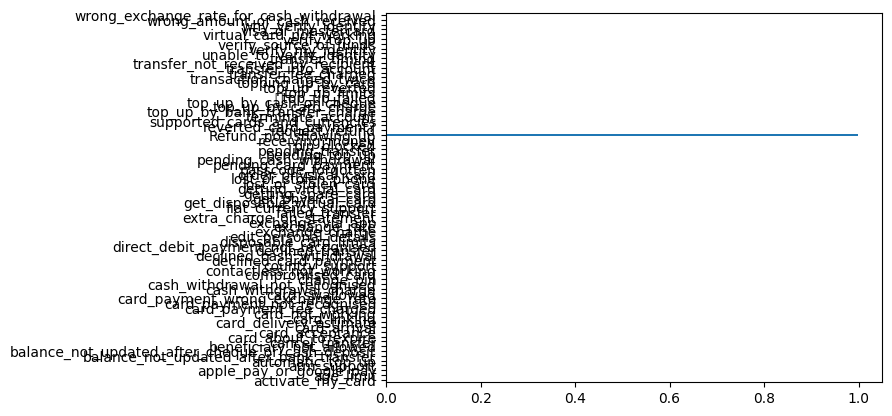

In [63]:
labels = ["activate_my_card",
    "age_limit",
    "apple_pay_or_google_pay",
    "atm_support",
    "automatic_top_up",
    "balance_not_updated_after_bank_transfer",
    "balance_not_updated_after_cheque_or_cash_deposit",
    "beneficiary_not_allowed" ,
    "cancel_transfer",
    "card_about_to_expire" ,
    "card_acceptance",
    "card_arrival",
    "card_delivery_estimate",
    "card_linking",
    "card_not_working",
    "card_payment_fee_charged",
    "card_payment_not_recognised",
    "card_payment_wrong_exchange_rate",
    "card_swallowed",
    "cash_withdrawal_charge",
    "cash_withdrawal_not_recognised",
    "change_pin" ,

    "compromised_card",
    "contactless_not_working",
    "country_support",
    "declined_card_payment",
    "declined_cash_withdrawal",
    "declined_transfer",
    "direct_debit_payment_not_recognised",
    "disposable_card_limits",
    "edit_personal_details",
    "exchange_charge",
    "exchange_rate",
    "exchange_via_app",
    "extra_charge_on_statement",
    "failed_transfer",
    "fiat_currency_support",
    "get_disposable_virtual_card",
    "get_physical_card",
    "getting_spare_card",
    "getting_virtual_card",
    "lost_or_stolen_card",
    "lost_or_stolen_phone",
    "order_physical_card",

    "passcode_forgotten",
    "pending_card_payment",
    "pending_cash_withdrawal",
    "pending_top_up" ,
    "pending_transfer",
    "pin_blocked",
    "receiving_money",
    "Refund_not_showing_up",
    "request_refund",
    "reverted_card_payment?",
    "supported_cards_and_currencies",
    "terminate_account",
    "top_up_by_bank_transfer_charge",
    "top_up_by_card_charge",
    "top_up_by_cash_or_cheque",
    "	top_up_failed",
    "top_up_limits",
    "top_up_reverted",
    "topping_up_by_card",
    "transaction_charged_twice",
    "transfer_fee_charged",
    "transfer_into_account",

    "transfer_not_received_by_recipient",
    "transfer_timing",
    "unable_to_verify_identity",
    "verify_my_identity",
    "verify_source_of_funds",
    "verify_top_up",
    "virtual_card_not_working",
    "visa_or_mastercard",
    "why_verify_identity",
    "wrong_amount_of_cash_received",
    "wrong_exchange_rate_for_cash_withdrawal"]
pd.Series(probs, index=labels).plot.barh()

In [64]:
label_number_bert = np.argmax(probs)

In [65]:
label_number_bert

51

In [66]:
label_name_bert = labels[label_number_bert]
label_name_bert

'Refund_not_showing_up'

**Roberta-based**

In [67]:
model_name = "roberta-base"
from transformers import AutoTokenizer, BertForSequenceClassification, AdamW
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


banking_encoded = banking.map(tokenize, batched=True, batch_size=None)
banking_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"],
)
banking_encoded.set_format("torch")
banking_encoded

Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10003
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1540
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1540
    })
})

In [68]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_labels = 77
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=77
).to(device )

Hypertuning to find the best parameters

In [69]:
from transformers import TrainingArguments
from transformers import Trainer

learning_rates = [2e-5, 3e-5]
batch_sizes = [64, 128]
num_epochs = [3, 4]


for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
            print(f"Hyperparameters: lr={learning_rate}, batch_size={batch_size}, epochs={epochs}")


            training_args = TrainingArguments(
                output_dir="results",
                optim="adamw_torch",
                learning_rate=learning_rate,
                weight_decay=0.01,
                per_device_train_batch_size=batch_size,
                num_train_epochs=epochs,
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                evaluation_strategy="epoch",
                save_strategy="epoch",
                disable_tqdm=False,
                logging_steps= len(banking_encoded["train"])// batch_size,
                seed = 23
            )


            trainer = Trainer(
                model=model,
                args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=banking_encoded["train"],
                eval_dataset=banking_encoded["val"],
            )


            trainer.train()


Hyperparameters: lr=2e-05, batch_size=64, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.530400,2.371901,0.670779,0.628680
2,2.009200,1.498198,0.800649,0.778664
3,1.471900,1.279858,0.827922,0.812687


Hyperparameters: lr=2e-05, batch_size=64, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.989900,0.657503,0.900000,0.898013
2,0.523800,0.460080,0.920130,0.920167
3,0.372500,0.391381,0.922727,0.922911
4,0.308700,0.369795,0.923377,0.923350


Hyperparameters: lr=2e-05, batch_size=128, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.279600,0.329409,0.927273,0.927402
2,0.194100,0.311596,0.925974,0.926290
3,0.155700,0.299232,0.930519,0.930913


Hyperparameters: lr=2e-05, batch_size=128, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.111900,0.307913,0.925325,0.925792
2,0.078600,0.298644,0.933766,0.933887
3,0.069600,0.299536,0.931818,0.932145
4,0.071900,0.300547,0.930519,0.930844


Hyperparameters: lr=3e-05, batch_size=64, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.095400,0.314299,0.925974,0.926178
2,0.055400,0.311337,0.931169,0.931352
3,0.031000,0.305632,0.935714,0.936090


Hyperparameters: lr=3e-05, batch_size=64, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.048200,0.394260,0.918831,0.919501
2,0.024000,0.368692,0.929221,0.929356
3,0.017500,0.384836,0.932468,0.932589
4,0.019000,0.382560,0.928571,0.928683


Hyperparameters: lr=3e-05, batch_size=128, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.024800,0.395532,0.927922,0.928188
2,0.013300,0.408007,0.931818,0.932187
3,0.014200,0.410884,0.931169,0.931100


Hyperparameters: lr=3e-05, batch_size=128, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.021600,0.437398,0.928571,0.928924
2,0.011900,0.455222,0.923377,0.923558
3,0.020100,0.406287,0.931818,0.931893
4,0.014400,0.415660,0.932468,0.932586


In [70]:
 training_args_best = TrainingArguments(
                output_dir="results",
                optim="adamw_torch",
                learning_rate=3e-5,
                weight_decay=0.01,
                per_device_train_batch_size=64,
                num_train_epochs=3,
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                evaluation_strategy="epoch",
                save_strategy="epoch",
                disable_tqdm=False,
                logging_steps= len(banking_encoded["train"])// 64,
                seed= 23
            )



trainer = Trainer(
                model=model,
                args=training_args_best,
                compute_metrics=compute_metrics,
                train_dataset=banking_encoded["train"],
                eval_dataset=banking_encoded["val"],

            )

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.018800,0.456365,0.934416,0.934588
2,0.012300,0.472789,0.931169,0.931107
3,0.003700,0.432110,0.932468,0.932519


TrainOutput(global_step=471, training_loss=0.011514050541979492, metrics={'train_runtime': 205.5533, 'train_samples_per_second': 145.991, 'train_steps_per_second': 2.291, 'total_flos': 1481440609293120.0, 'train_loss': 0.011514050541979492, 'epoch': 3.0})

In [71]:
# evaluating the model performance on the test set

banking_test = banking_encoded["test"]['text']
input_ids = tokenizer(banking_test, padding = True, truncation = True, return_tensors = 'pt')

with torch.no_grad() :
  inputs = input_ids.to('cuda')
  outputs = model(**inputs)
  logits = outputs.logits

probs = torch.softmax(logits, dim=1).cpu().numpy()

y_pred_roberta = np.argmax(probs,axis=1)

In [72]:
y_pred_roberta

array([35, 29, 73, ..., 65, 24, 38])

In [73]:
from sklearn.metrics import confusion_matrix


accuracy = accuracy_score(y_test, y_pred_roberta)
f1score = f1_score(y_test, y_pred_roberta, average = 'weighted')
confusion = confusion_matrix(y_test, y_pred_roberta)
classification_rep = classification_report(y_test, y_pred_roberta)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1score}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9279220779220779
F1 Score: 0.9277954567773404
Confusion Matrix:
[[22  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 19  0]
 [ 0  0  0 ...  0  0 19]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        18
           3       0.96      1.00      0.98        25
           4       0.94      0.84      0.89        19
           5       0.95      0.72      0.82        25
           6       1.00      0.96      0.98        27
           7       1.00      0.84      0.91        19
           8       1.00      1.00      1.00        18
           9       0.89      1.00      0.94        16
          10       0.94      0.75      0.83        20
          11       0.93      1.00      0.96        13
          12       1.00      0.91      0.9

In [74]:
custom_text = 'I have returned an item at ZARA, they say my refund is made, my bank account does not show it'

In [75]:
input_tensor = tokenizer.encode(custom_text, return_tensors="pt").to('cuda')
with torch.no_grad():
    logits = model(input_tensor).logits

In [76]:
logits = logits.cpu().flatten()
probs = scipy.special.softmax(logits.numpy())

probs

array([6.2384345e-07, 3.6078359e-06, 2.2334664e-06, 9.1748552e-07,
       1.4012402e-06, 6.8069340e-07, 1.0268220e-06, 3.5611372e-06,
       4.0345023e-07, 1.1833671e-06, 5.6310296e-07, 3.7464890e-06,
       8.5470060e-07, 1.6281388e-06, 4.2450509e-07, 4.5106484e-07,
       3.1105374e-06, 1.6610849e-07, 1.1731736e-05, 1.3188478e-06,
       3.1647215e-07, 1.5014489e-06, 4.6778555e-07, 9.2840691e-07,
       2.9269854e-06, 6.1131595e-07, 2.9219375e-06, 2.0243122e-06,
       3.3975778e-06, 6.4729852e-07, 1.5492606e-06, 2.0240371e-07,
       1.3203870e-06, 2.0372775e-07, 2.2592108e-07, 4.3897917e-06,
       3.2100172e-06, 5.3673557e-06, 2.6041166e-06, 2.2017166e-06,
       5.2686091e-06, 1.1152182e-06, 5.7773259e-06, 4.5473007e-07,
       1.9290442e-06, 1.5811690e-06, 5.1295838e-06, 4.0703294e-06,
       4.2397210e-06, 1.6162745e-06, 9.0298221e-07, 9.9985838e-01,
       2.7126316e-06, 9.9131023e-07, 1.7640444e-06, 1.8260027e-06,
       1.3567501e-06, 1.2231828e-06, 1.0444344e-06, 5.3180423e

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


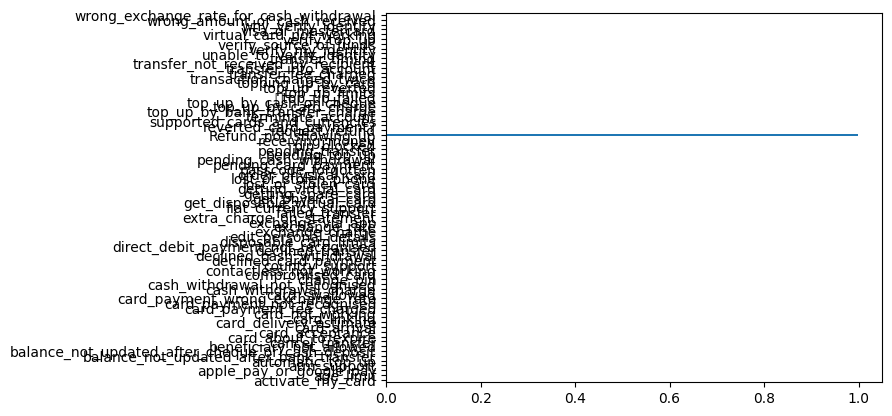

In [77]:
pd.Series(probs, index=labels).plot.barh()

In [78]:
label_number_roberta = np.argmax(probs)

In [79]:
label_name_roberta = labels[label_number_roberta]
label_name_roberta

'Refund_not_showing_up'

**Distilbert-Base-Uncased**

In [80]:
model_name = "distilbert-base-uncased"
from transformers import AutoTokenizer, BertForSequenceClassification, AdamW
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


banking_encoded = banking.map(tokenize, batched=True, batch_size=None)
banking_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"],
)
banking_encoded.set_format("torch")
banking_encoded

Map:   0%|          | 0/10003 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 10003
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1540
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 1540
    })
})

In [81]:
num_labels = 77
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=77
).to('cuda' if torch.cuda.is_available() else 'cpu' )

Checking the best hyperparameters


In [82]:
from transformers import TrainingArguments
from transformers import Trainer

learning_rates = [2e-5, 3e-5]
batch_sizes = [64, 128]
num_epochs = [3, 4]


for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
            print(f"Hyperparameters: lr={learning_rate}, batch_size={batch_size}, epochs={epochs}")


            training_args = TrainingArguments(
                output_dir="results",
                optim="adamw_torch",
                learning_rate=learning_rate,
                weight_decay=0.01,
                per_device_train_batch_size=batch_size,
                num_train_epochs=epochs,
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                evaluation_strategy="epoch",
                save_strategy="epoch",
                disable_tqdm=False,
                logging_steps= len(banking_encoded["train"])// batch_size,
                seed= 23
            )


            trainer = Trainer(
                model=model,
                args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=banking_encoded["train"],
                eval_dataset=banking_encoded["val"],
            )


            trainer.train()


Hyperparameters: lr=2e-05, batch_size=64, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.909400,3.296200,0.503247,0.440624
2,2.918700,2.584249,0.608442,0.562113
3,2.448100,2.364732,0.640909,0.603396


Hyperparameters: lr=2e-05, batch_size=64, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.876500,1.465892,0.764286,0.744207
2,1.176600,1.030038,0.840909,0.831820
3,0.857000,0.835573,0.862338,0.856572
4,0.731400,0.776152,0.864935,0.859467


Hyperparameters: lr=2e-05, batch_size=128, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.615400,0.594686,0.881169,0.878396
2,0.454900,0.518157,0.895455,0.894925
3,0.386400,0.490786,0.897403,0.897789


Hyperparameters: lr=2e-05, batch_size=128, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.311300,0.414162,0.905844,0.906247
2,0.231100,0.383453,0.905844,0.906547
3,0.196000,0.361599,0.914286,0.914892
4,0.180200,0.357997,0.911039,0.911740


Hyperparameters: lr=3e-05, batch_size=64, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.165200,0.338336,0.918182,0.918412
2,0.090300,0.324854,0.915584,0.916208
3,0.062700,0.319676,0.916883,0.917658


Hyperparameters: lr=3e-05, batch_size=64, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.067100,0.356880,0.907143,0.907814
2,0.058300,0.330565,0.917532,0.918166
3,0.036100,0.344211,0.916234,0.916906
4,0.025900,0.330246,0.918182,0.919031


Hyperparameters: lr=3e-05, batch_size=128, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.023900,0.378263,0.915584,0.916351
2,0.016000,0.362304,0.919481,0.920067
3,0.011100,0.351365,0.918831,0.919617


Hyperparameters: lr=3e-05, batch_size=128, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.008400,0.419583,0.911688,0.912111
2,0.008100,0.415876,0.918831,0.919008
3,0.009200,0.393564,0.920130,0.920523
4,0.008800,0.394163,0.924026,0.924331


In [84]:
 training_args_best = TrainingArguments(
                output_dir="results",
                optim="adamw_torch",
                learning_rate=3e-5,
                weight_decay=0.01,
                per_device_train_batch_size=128,
                num_train_epochs=4,
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                evaluation_strategy="epoch",
                save_strategy="epoch",
                disable_tqdm=False,
                logging_steps= len(banking_encoded["train"])// 128,
                seed= 23
            )



trainer = Trainer(
                model=model,
                args=training_args_best,
                compute_metrics=compute_metrics,
                train_dataset=banking_encoded["train"],
                eval_dataset=banking_encoded["val"],

            )

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.003200,0.485626,0.913636,0.914268
2,0.006700,0.460680,0.917532,0.918216
3,0.004100,0.451020,0.918831,0.919657
4,0.003300,0.451842,0.920130,0.920209


TrainOutput(global_step=316, training_loss=0.0042579990997321055, metrics={'train_runtime': 144.053, 'train_samples_per_second': 277.759, 'train_steps_per_second': 2.194, 'total_flos': 1015864704971088.0, 'train_loss': 0.0042579990997321055, 'epoch': 4.0})

In [85]:
# evaluating the model performance on the test set

banking_test = banking_encoded["test"]['text']
input_ids = tokenizer(banking_test, padding = True, truncation = True, return_tensors = 'pt')

with torch.no_grad() :
  inputs = input_ids.to('cuda')
  outputs = model(**inputs)
  logits = outputs.logits

probs = torch.softmax(logits, dim=1).cpu().numpy()

y_pred_distilbert = np.argmax(probs,axis=1)

In [86]:
y_pred_distilbert

array([35, 29, 73, ..., 65, 24, 38])

In [87]:
from sklearn.metrics import confusion_matrix


accuracy = accuracy_score(y_test, y_pred_distilbert)
f1score = f1_score(y_test, y_pred_distilbert, average = 'weighted')
confusion = confusion_matrix(y_test, y_pred_distilbert)
classification_rep = classification_report(y_test, y_pred_distilbert)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1score}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.9311688311688312
F1 Score: 0.9312650349926549
Confusion Matrix:
[[22  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  0  0 ... 17  0  0]
 [ 0  0  0 ...  0 19  0]
 [ 0  0  0 ...  0  0 18]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        22
           1       0.94      1.00      0.97        15
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        25
           4       1.00      0.89      0.94        19
           5       0.87      0.80      0.83        25
           6       1.00      0.96      0.98        27
           7       1.00      0.84      0.91        19
           8       1.00      1.00      1.00        18
           9       1.00      1.00      1.00        16
          10       1.00      0.85      0.92        20
          11       0.81      1.00      0.90        13
          12       0.95      0.86      0.9

In [88]:
custom_text = "I have returned an item at ZARA, they say my refund is made, my bank account does not show it"
input_tensor = tokenizer.encode(custom_text, return_tensors="pt").to('cuda')
with torch.no_grad():
    logits = model(input_tensor).logits

In [89]:
logits = logits.cpu().flatten()
probs = scipy.special.softmax(logits.numpy())

probs

array([1.25108841e-07, 1.48329944e-08, 7.93761558e-07, 6.48668745e-08,
       5.64002214e-08, 3.26967165e-06, 7.87113186e-06, 6.23679384e-08,
       6.44602665e-07, 6.24255108e-07, 2.75134457e-08, 2.48737115e-06,
       1.10453662e-07, 6.21321448e-08, 1.23271491e-06, 6.30956549e-08,
       1.24049777e-07, 9.18838225e-07, 7.52388075e-07, 3.37397026e-08,
       2.13184576e-05, 3.86778339e-07, 1.08410291e-07, 1.38146152e-06,
       1.07148502e-07, 3.78564368e-06, 1.66689813e-06, 1.68847339e-06,
       5.37793494e-06, 1.43870082e-07, 1.32430239e-06, 3.67448720e-08,
       1.56365161e-07, 9.44713747e-07, 2.18725361e-07, 5.94165442e-07,
       7.08518087e-07, 1.65258982e-07, 6.07071172e-07, 1.89129892e-07,
       1.14984047e-07, 1.31850982e-07, 2.36376854e-06, 1.66599197e-08,
       9.07667584e-07, 4.04734578e-07, 8.27109034e-06, 1.62348238e-06,
       3.94405242e-06, 2.01363818e-07, 3.27065699e-08, 9.99881029e-01,
       1.69465766e-05, 5.78233994e-06, 7.07996605e-07, 1.01006879e-06,
      

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


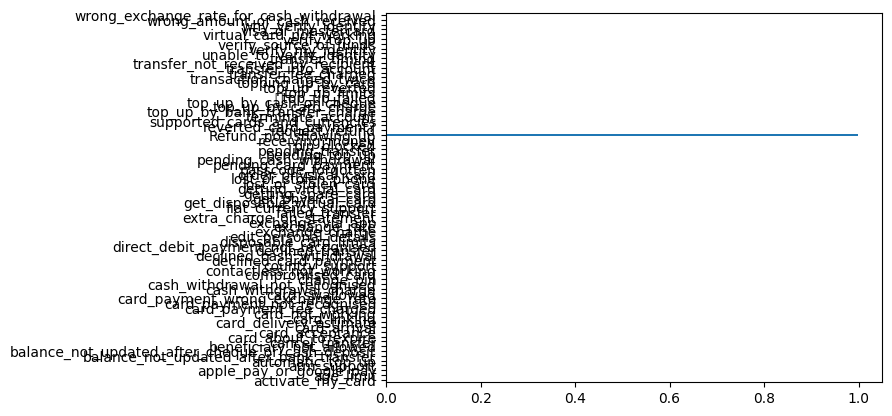

In [90]:
labels = ["activate_my_card",
    "age_limit",
    "apple_pay_or_google_pay",
    "atm_support",
    "automatic_top_up",
    "balance_not_updated_after_bank_transfer",
    "balance_not_updated_after_cheque_or_cash_deposit",
    "beneficiary_not_allowed" ,
    "cancel_transfer",
    "card_about_to_expire" ,
    "card_acceptance",
    "card_arrival",
    "card_delivery_estimate",
    "card_linking",
    "card_not_working",
    "card_payment_fee_charged",
    "card_payment_not_recognised",
    "card_payment_wrong_exchange_rate",
    "card_swallowed",
    "cash_withdrawal_charge",
    "cash_withdrawal_not_recognised",
    "change_pin" ,

    "compromised_card",
    "contactless_not_working",
    "country_support",
    "declined_card_payment",
    "declined_cash_withdrawal",
    "declined_transfer",
    "direct_debit_payment_not_recognised",
    "disposable_card_limits",
    "edit_personal_details",
    "exchange_charge",
    "exchange_rate",
    "exchange_via_app",
    "extra_charge_on_statement",
    "failed_transfer",
    "fiat_currency_support",
    "get_disposable_virtual_card",
    "get_physical_card",
    "getting_spare_card",
    "getting_virtual_card",
    "lost_or_stolen_card",
    "lost_or_stolen_phone",
    "order_physical_card",

    "passcode_forgotten",
    "pending_card_payment",
    "pending_cash_withdrawal",
    "pending_top_up" ,
    "pending_transfer",
    "pin_blocked",
    "receiving_money",
    "Refund_not_showing_up",
    "request_refund",
    "reverted_card_payment?",
    "supported_cards_and_currencies",
    "terminate_account",
    "top_up_by_bank_transfer_charge",
    "top_up_by_card_charge",
    "top_up_by_cash_or_cheque",
    "	top_up_failed",
    "top_up_limits",
    "top_up_reverted",
    "topping_up_by_card",
    "transaction_charged_twice",
    "transfer_fee_charged",
    "transfer_into_account",

    "transfer_not_received_by_recipient",
    "transfer_timing",
    "unable_to_verify_identity",
    "verify_my_identity",
    "verify_source_of_funds",
    "verify_top_up",
    "virtual_card_not_working",
    "visa_or_mastercard",
    "why_verify_identity",
    "wrong_amount_of_cash_received",
    "wrong_exchange_rate_for_cash_withdrawal"]
pd.Series(probs, index=labels).plot.barh()

In [91]:
label_number_distilbert = np.argmax(probs)

In [92]:
label_name_distilbert = labels[label_number_distilbert]
label_name_distilbert

'Refund_not_showing_up'

**XLNet-Base-Cased**

In [37]:
model_name = "XLNet-base-cased"
from transformers import AutoTokenizer, AdamW
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)


banking_encoded = banking.map(tokenize, batched=True, batch_size=None)
banking_encoded.set_format(
    "torch",
    columns=["input_ids", "attention_mask", "label"],
)
banking_encoded.set_format("torch")
banking_encoded


Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

Map:   0%|          | 0/1540 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10003
    })
    val: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1540
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1540
    })
})

In [38]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_labels = 77
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=77
).to(device )

Hypertraining to find the best parameters

In [39]:
from transformers import TrainingArguments
from transformers import Trainer

learning_rates = [2e-5, 3e-5]
batch_sizes = [64, 128]
num_epochs = [3, 4]


for learning_rate in learning_rates:
    for batch_size in batch_sizes:
        for epochs in num_epochs:
            print(f"Hyperparameters: lr={learning_rate}, batch_size={batch_size}, epochs={epochs}")


            training_args = TrainingArguments(
                output_dir="results",
                optim="adamw_torch",
                learning_rate=learning_rate,
                weight_decay=0.01,
                per_device_train_batch_size=batch_size,
                num_train_epochs=epochs,
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                evaluation_strategy="epoch",
                save_strategy="epoch",
                disable_tqdm=False,
                logging_steps= len(banking_encoded["train"])// batch_size,
                seed= 23
            )


            trainer = Trainer(
                model=model,
                args=training_args,
                compute_metrics=compute_metrics,
                train_dataset=banking_encoded["train"],
                eval_dataset=banking_encoded["val"],
            )


            trainer.train()


Hyperparameters: lr=2e-05, batch_size=64, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,3.960700,2.922941,0.479870,0.430560
2,2.432800,1.652100,0.718831,0.696964
3,1.683900,1.341394,0.763636,0.749778


Hyperparameters: lr=2e-05, batch_size=64, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.106900,0.641059,0.858442,0.853985
2,0.543200,0.429285,0.898701,0.898689
3,0.367600,0.370222,0.901948,0.902277
4,0.303600,0.344496,0.912338,0.912201


Hyperparameters: lr=2e-05, batch_size=128, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.286300,0.326261,0.907792,0.907893
2,0.204700,0.318782,0.912987,0.912895
3,0.158200,0.299233,0.916234,0.916331


Hyperparameters: lr=2e-05, batch_size=128, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.090200,0.327557,0.917532,0.917254
2,0.067900,0.316221,0.922727,0.922541
3,0.066000,0.313803,0.919481,0.919678
4,0.076900,0.312023,0.923377,0.923310


Hyperparameters: lr=3e-05, batch_size=64, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.089100,0.376891,0.914286,0.914288
2,0.044200,0.375032,0.920779,0.921187
3,0.026100,0.370708,0.925325,0.925571


Hyperparameters: lr=3e-05, batch_size=64, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.030600,0.416545,0.920779,0.921257
2,0.022400,0.433651,0.914935,0.915193
3,0.017100,0.428480,0.920130,0.920594
4,0.019500,0.421364,0.919481,0.919418


Hyperparameters: lr=3e-05, batch_size=128, epochs=3


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.021700,0.464867,0.914286,0.914453
2,0.011600,0.453588,0.918831,0.918880
3,0.011100,0.441452,0.924026,0.924553


Hyperparameters: lr=3e-05, batch_size=128, epochs=4


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.013800,0.488113,0.916234,0.916515
2,0.009400,0.447475,0.922727,0.922874
3,0.010400,0.450960,0.919481,0.920106
4,0.025900,0.444228,0.927922,0.928119


In [40]:
 training_args_best = TrainingArguments(
                output_dir="results",
                optim="adamw_torch",
                learning_rate=3e-5,
                weight_decay=0.01,
                per_device_train_batch_size=128,
                num_train_epochs=4,
                load_best_model_at_end=True,
                metric_for_best_model="accuracy",
                evaluation_strategy="epoch",
                save_strategy="epoch",
                disable_tqdm=False,
                logging_steps= len(banking_encoded["train"])// 128,
                seed= 23
            )



trainer = Trainer(
                model=model,
                args=training_args_best,
                compute_metrics=compute_metrics,
                train_dataset=banking_encoded["train"],
                eval_dataset=banking_encoded["val"],

            )

trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.011300,0.543078,0.911039,0.911993
2,0.011100,0.547707,0.912987,0.913572
3,0.009200,0.541686,0.917532,0.918318
4,0.010700,0.528400,0.919481,0.919725


TrainOutput(global_step=316, training_loss=0.010681732380880585, metrics={'train_runtime': 370.3449, 'train_samples_per_second': 108.04, 'train_steps_per_second': 0.853, 'total_flos': 2183125897666896.0, 'train_loss': 0.010681732380880585, 'epoch': 4.0})

In [41]:
# evaluating the model performance on the test set

banking_test = banking_encoded["test"]['text']
input_ids = tokenizer(banking_test, padding = True, truncation = True, return_tensors = 'pt')

with torch.no_grad() :
  inputs = input_ids.to('cuda')
  outputs = model(**inputs)
  logits = outputs.logits

probs = torch.softmax(logits, dim=1).cpu().numpy()

y_pred_xlnet = np.argmax(probs,axis=1)

In [42]:
y_pred_xlnet

array([35, 29, 73, ..., 65, 24, 38])

In [44]:
from sklearn.metrics import confusion_matrix


accuracy = accuracy_score(y_test, y_pred_xlnet)
f1score = f1_score(y_test, y_pred_xlnet, average = 'weighted')
confusion = confusion_matrix(y_test, y_pred_xlnet)
classification_rep = classification_report(y_test, y_pred_xlnet)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1score}')
print(f'Confusion Matrix:\n{confusion}')
print(f'Classification Report:\n{classification_rep}')

Accuracy: 0.938961038961039
F1 Score: 0.9387416408512391
Confusion Matrix:
[[22  0  0 ...  0  0  0]
 [ 0 15  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  0  0 ... 17  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  0  0 ...  0  0 19]]
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98        22
           1       1.00      1.00      1.00        15
           2       1.00      1.00      1.00        18
           3       1.00      1.00      1.00        25
           4       1.00      0.79      0.88        19
           5       0.91      0.84      0.87        25
           6       1.00      0.93      0.96        27
           7       0.89      0.84      0.86        19
           8       1.00      1.00      1.00        18
           9       0.94      1.00      0.97        16
          10       0.95      0.90      0.92        20
          11       0.87      1.00      0.93        13
          12       1.00      0.91      0.95

In [46]:
custom_text = 'I have returned an item at ZARA, they say my refund is made, my bank account does not show it'
input_tensor = tokenizer.encode(custom_text, return_tensors="pt").to('cuda')
with torch.no_grad():
    logits = model(input_tensor).logits

In [47]:
logits = logits.cpu().flatten()
probs = scipy.special.softmax(logits.numpy())

probs

array([8.3751750e-08, 1.6250542e-07, 3.4749709e-07, 5.9023762e-07,
       4.3753781e-07, 5.4200103e-07, 2.5742600e-07, 8.6934654e-07,
       3.4744707e-07, 9.2219096e-07, 8.5853287e-07, 2.0954349e-07,
       1.8397451e-06, 8.7946539e-08, 3.2608057e-07, 2.1776529e-07,
       4.0067718e-07, 5.5489831e-08, 1.5346474e-07, 1.5073246e-07,
       1.9418290e-07, 2.2602086e-07, 1.0717448e-07, 5.8201368e-07,
       8.5638868e-07, 1.3000873e-06, 1.8177601e-06, 7.0165021e-07,
       2.8275267e-06, 2.7217624e-07, 1.3325976e-07, 2.0564375e-08,
       7.8975035e-08, 4.4987056e-07, 4.0798761e-07, 5.0363559e-07,
       1.2242041e-06, 2.1782571e-07, 3.3814234e-07, 1.0457245e-07,
       1.2832962e-06, 4.6117756e-07, 2.0546860e-07, 3.7895904e-07,
       2.7212575e-08, 7.5488003e-07, 5.0577050e-06, 2.2717981e-07,
       1.0307534e-06, 3.3395438e-07, 7.1415798e-08, 9.9994040e-01,
       1.4177565e-06, 4.6555874e-06, 4.8945958e-07, 2.9521752e-07,
       1.9735748e-07, 1.1487096e-07, 8.0886579e-08, 5.6942503e

<Axes: >

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


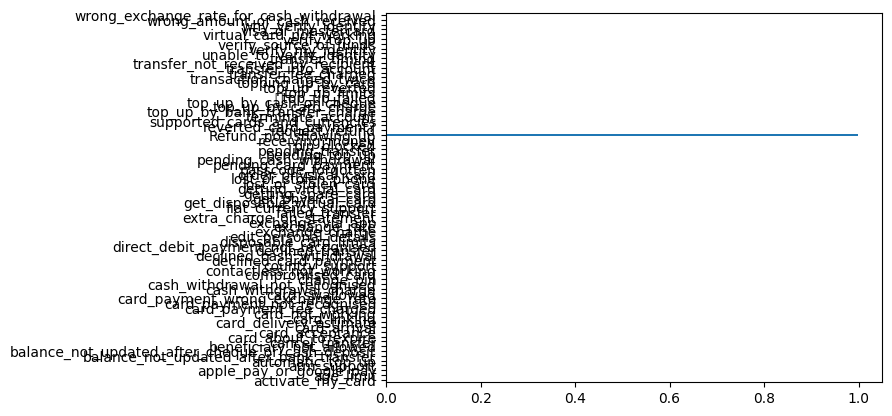

In [48]:
pd.Series(probs, index=labels).plot.barh()

In [49]:
label_number_xlnet = np.argmax(probs)

In [50]:
label_name_xlnet = labels[label_number_xlnet]
label_name_xlnet

'Refund_not_showing_up'